# Hyperparameter search analysis

In [ ]:
%matplotlib inline
from master_scripts.data_functions import get_git_root
import json
import pandas
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

Base functions for importing. To-be transferred to data_functions/analysis_functions when done

In [106]:
def load_experiment(e_id):
    repo_root = get_git_root()
    e_path = repo_root + "experiments/searches/"
    with open(e_path + e_id + ".json", "r") as fp:
        e = json.load(fp)
    return e

def load_hparam_search(name):
    """ Reads scsv-formatted hparam search file spec to pandas DF,
    and loads additional metrics into the dataframe.
    """
    repo_root = get_git_root()
    hpath = repo_root + "experiments/"
    df = pandas.read_json(hpath + name, orient='index').rename_axis('id').reset_index()
    # JSON convert the tuples in hparam search to list when it's interpreted.
    # Convert the values to str to make it workable
    df['kernel_size'] = [str(x) for x in df['kernel_size'].values]
    # Add additional metrics to df
    accs = []
    f1 = []
    mcc = []
    auc = []
    for e_id in df['id']:
        e = load_experiment(e_id)
        accs.append(e['metrics']['accuracy_score'])
        f1.append(e['metrics']['f1_score'])
        mcc.append(e['metrics']['matthews_corrcoef'])
        auc.append(e['metrics']['roc_auc_score'])
    df['accuracy_score'] = accs
    df['f1_score'] = f1
    df['matthews_corrcoef'] = mcc
    df['roc_auc_score'] = auc
    return df

## Architecture search - kernel size
The idea is to verify that increasing the kernel size in a one-conv2d-layer network doesn't significantly increase classification performance,
or at least give an indication of that. Citing the VGG paper, it can be argued that 3x3 kernel_size is the optimal one, because you get fewer parameters
but with greater expressibility.

If the goal is to increase the size of a layer's 'field of view', the pseudo-parameter to be tuned should be the ['receptive field'](https://distill.pub/2019/computing-receptive-fields/)

In [95]:
# Load data, split on kernel size and extract only the columns we want
df = load_hparam_search("architecture_search_seeded.json")
test = df.groupby(['kernel_size'])[['filters', 'dense_size','matthews_corrcoef']]
results = {}
for k in test.groups.keys():
    results[k] = test.get_group(k).pivot('filters', 'dense_size', 'matthews_corrcoef')

Text(0.5, 0.98, 'Matthews Correlation Coeffiction as a function of number of filters and size of hidden dense layer')

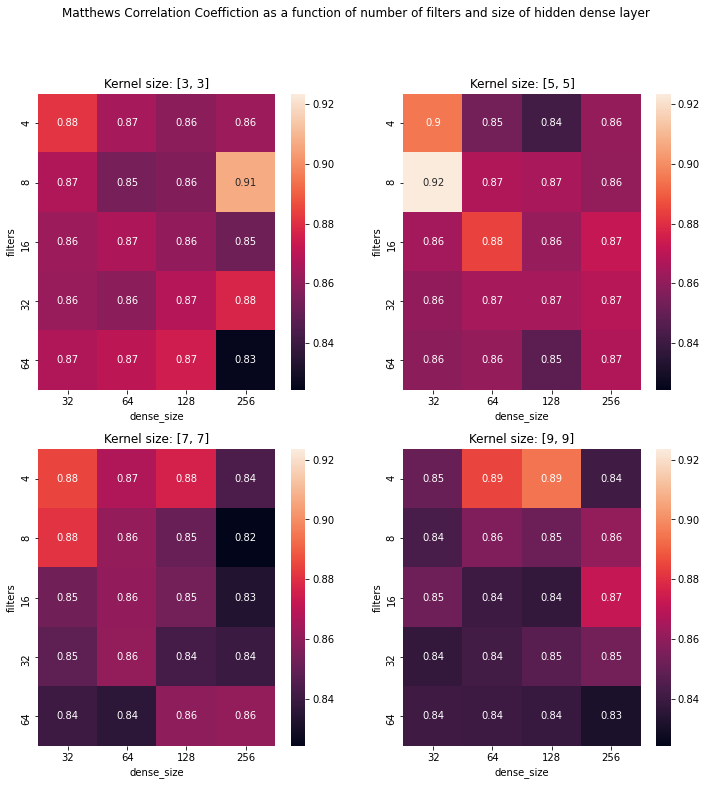

In [105]:
# Heatmap for each kernel size
# Get minimum mcc and max mcc from df to use as vmin, vmax args
vmin = df['matthews_corrcoef'].min()
vmax = df['matthews_corrcoef'].max()
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
for k, ax in zip(results.keys(), axes.flatten()):
    sns.heatmap(results[k], square=True, annot=True, ax=ax, vmin=vmin, vmax=vmax)
    ax.set_title("Kernel size: " + k)
fig.suptitle("Matthews Correlation Coeffiction as a function of number of filters and size of hidden dense layer")

* no significant dependence on dense layer size.
* no significant gain in performance from increasing the kernel_size.
* number of filters also appears to not be very influential. It may be that the model is unable to fit properly well to the training data.